In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize



In [2]:
# Download NLTK data (if not already downloaded)
nltk.download('punkt')
nltk.download('stopwords')



[nltk_data] Downloading package punkt to /Users/rony/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/rony/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Load the dataset
data = pd.read_csv('/Users/rony/Desktop/twitter sentiment analysis/twitter_training.csv')


In [4]:
# Ensure the text column has no missing values and is of type string
data['Tweet content'] = data['Tweet content'].fillna('').astype(str)

In [5]:
# Define text preprocessing function
def preprocess_text(text):
    if not isinstance(text, str):
        text = str(text)
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    return ' '.join(tokens)

# Apply preprocessing
data['clean_text'] = data['Tweet content'].apply(preprocess_text)

# Prepare data for model
X = data['clean_text']
y = data['sentiment']  

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Build and train the model with TF-IDF vectorization and Naive Bayes
pipeline = Pipeline([
    ('vect', TfidfVectorizer()),  # TF-IDF vectorization
    ('clf', MultinomialNB())      # Naive Bayes classifier
])

# Define hyperparameters for GridSearch
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],  # Unigrams or bigrams
    'vect__max_df': [0.9, 1.0],  # Maximum document frequency
    'vect__min_df': [1, 5]  # Minimum document frequency
}

# Perform GridSearch for hyperparameter tuning
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)

# Use the best model from GridSearch
best_model = grid_search.best_estimator_

# Make predictions and evaluate the model
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Best parameters found:  {'vect__max_df': 0.9, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}
Accuracy: 0.8303541541139452
              precision    recall  f1-score   support

  Irrelevant       0.99      0.58      0.73      2592
    Negative       0.75      0.96      0.84      4519
     Neutral       0.90      0.78      0.84      3596
    Positive       0.83      0.89      0.86      4230

    accuracy                           0.83     14937
   macro avg       0.87      0.80      0.82     14937
weighted avg       0.85      0.83      0.83     14937



Cross-validation scores:  [0.50880364 0.4478811  0.375      0.40285217 0.49022496]
Mean cross-validation score:  0.44495237433392365


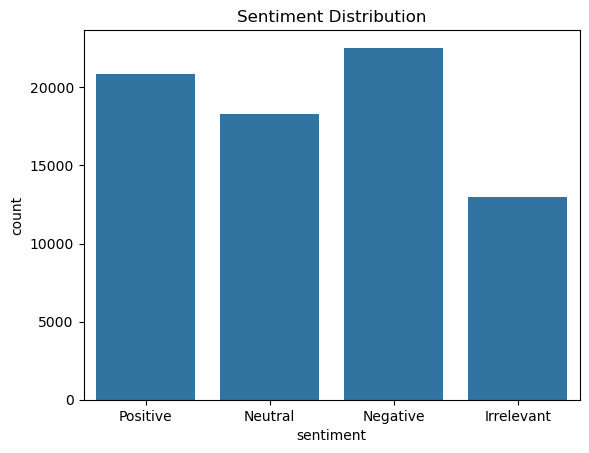

In [7]:
# Cross-validation scores
cross_val_scores = cross_val_score(best_model, X, y, cv=5)
print("Cross-validation scores: ", cross_val_scores)
print("Mean cross-validation score: ", cross_val_scores.mean())

# Visualize sentiment distribution
sns.countplot(data=data, x='sentiment')  
plt.title('Sentiment Distribution')
plt.show()




In [ ]:
# Function to predict sentiment of user input
def predict_sentiment(text):
    cleaned_text = preprocess_text(text)
    prediction = best_model.predict([cleaned_text])
    return prediction[0]

# Take user input and predict sentiment
while True:
    user_input = input("Enter a tweet to analyze sentiment (or type 'exit' to quit): ")
    if user_input.lower() == 'exit':
        break
    sentiment = predict_sentiment(user_input)
    print(f"Predicted Sentiment: {sentiment}")